In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
df=pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [162]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [163]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Dropping off the useless data**

In [164]:
columns_to_drop = ['Cabin', 'PassengerId', 'Ticket', 'Name']
print(f"Dropping columns: {columns_to_drop}")
df = df.drop(columns=columns_to_drop)

Dropping columns: ['Cabin', 'PassengerId', 'Ticket', 'Name']


**Dropping rows with null values**

In [165]:
df = df.dropna(subset=['Embarked','Age'])

In [166]:
#binary encoding
df['Sex'] = df['Sex'].str.strip().str.lower().map({'male': 1, 'female': 0})

#one hot encoding
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True, dtype=int)

In [167]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked_Q', 'Embarked_S']]
y = df['Survived']
if hasattr(X, "values"):      # if it's a pandas DataFrame
    X = X.values
X = X.astype(float)

In [168]:
# 1. Standardize the data
means = X.mean(axis=0)
stds = X.std(axis=0, ddof=1)   # sample std (ddof=1)
X_std = (X - means) / stds

In [169]:
# 2. Covariance matrix computation
cov_matrix = np.cov(X_std, rowvar=False)

In [170]:
# 3. Eigenvalues and eigenvectors of covariance
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [171]:
# 4. Sort principal components by eigenvalue
# largest eigenvalues first
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]



In [172]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
print("\nExplained Variance Ratio:", explained_variance_ratio)



Explained Variance Ratio: [0.31120476 0.22941755 0.18334532 0.12881979 0.08580188 0.06141071]


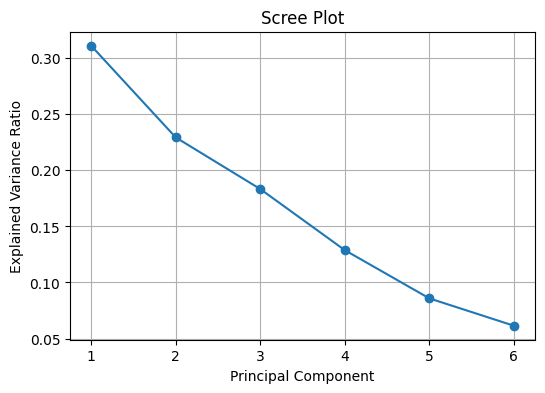

In [173]:

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_variance_ratio)+1),
         explained_variance_ratio, marker='o')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance_ratio)+1))
plt.grid(True)
plt.show()

In [200]:
n_components = 3   # decided from the graph

# principal components (each column is a PC direction)
components = eigenvectors[:, :n_components]
print("Components shape:", components.shape)   # (n_features, 3)

# ---- project standardized data onto these 3 PCs ----
X_pca = np.dot(X_std, components)
print("X_pca shape:", X_pca.shape) 

Components shape: (6, 3)
X_pca shape: (712, 3)


In [201]:
y_svm = y.copy()
y_svm = y_svm.replace({0: -1, 1: 1})
y_svm = y_svm.values.astype(float)

X = X_pca.astype(float)

In [202]:
# train / test split  
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y_svm[:split], y_svm[split:]


In [203]:
# Initialize SVM parameters
n_samples, n_features = X_train.shape
w = np.zeros(n_features)   # weights
b = 0.0                    # bias

learning_rate = 0.001
lambda_param = 0.01        # regularization strength
n_epochs = 5000            # passes over the data


In [204]:
# 4) Training loop (SGD on hinge loss)
for epoch in range(n_epochs):
    for i in range(n_samples):
        x_i = X_train[i]
        y_i = y_train[i]

        condition = y_i * (np.dot(x_i, w) + b)

        if condition >= 1:
            # correctly classified with margin
            w = w - learning_rate * (2 * lambda_param * w)
            # b stays same
        else:
            # misclassified or within margin
            w = w + learning_rate * (y_i * x_i - 2 * lambda_param * w)
            b = b + learning_rate * y_i

In [205]:
# Prediction function
def svm_predict(X_input):
    linear_output = np.dot(X_input, w) + b
    y_pred = np.sign(linear_output)      # returns -1 or +1
    return y_pred

In [206]:
# Evaluate on train and test
y_train_pred = svm_predict(X_train)
y_test_pred  = svm_predict(X_test)

# convert back to {0,1} if you want to compare with original Survived
y_train_pred01 = (y_train_pred == 1).astype(int)
y_test_pred01  = (y_test_pred == 1).astype(int)

y_train_true01 = (y_train == 1).astype(int)
y_test_true01  = (y_test == 1).astype(int)

train_accuracy = np.mean(y_train_pred01 == y_train_true01)
test_accuracy  = np.mean(y_test_pred01  == y_test_true01)

print("Train accuracy:", train_accuracy)
print("Test accuracy :", test_accuracy)
print("Weights w:", w)
print("Bias b:", b)


Train accuracy: 0.7697715289982425
Test accuracy : 0.8321678321678322
Weights w: [ 0.56458585  0.09058175 -0.85436488]
Bias b: -0.2620000000000002


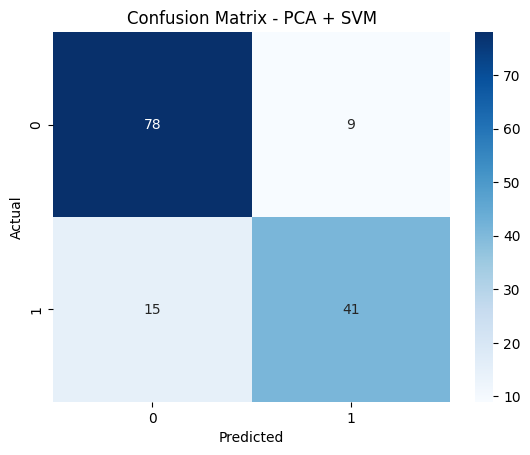

In [207]:
# ===== CONFUSION MATRIX PLOT =====
from pandas import crosstab

cm = crosstab(y_test_true01, y_test_pred01, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - PCA + SVM")
plt.show()
